# load libraries and init

In [2]:
import pandas as pd
import numpy as np

np.random.seed(67)

In [3]:
data = pd.read_csv('MSF_full_data_with_topics_and_factors - data_with_topics_and_factors.csv')

In [5]:
data.shape

(3061, 48)

In [10]:
data.columns

Index(['index', 'send_dt', 'month', 'send_time', 'send_number', 'campaign',
       'email_name', 'category', 'text', 'emails_sent', 'emails_delivered',
       'undeliverable', 'total_clicks', 'unique_clicks', 'unique_opens',
       'unsubscribes', 'unique_complaints', 'total_complaints', 'gifts',
       'revenue', 'Audience', 'polarity_score', 'subjectivity_score',
       'processed_text', 'id', 'topic', 'topic_named', 'open_rate',
       'click_rate', 'donation_rate', 'revenue_1k', 'send_group',
       'Open_Rate_nw', 'Click_Rate_nw', 'Donation_Rate_nw', 'revenue_1k_new',
       'Inquisitive', 'Caring', 'Grateful', 'Assertive', 'Urgent', 'Neutral',
       'Excited', 'Compassionate', 'emo value_original', 'emo_class_original',
       'top_factor_score', 'top_factor_label'],
      dtype='object')

In [21]:
data.Open_Rate_nw = data.unique_opens / data.emails_sent
data.Click_Rate_nw = data.unique_clicks / data.emails_sent
data.Donation_Rate_nw = data.gifts / data.emails_sent

In [22]:
data.revenue_1k_new

0           $0
1         $564
3         $894
5           $0
7         $621
         ...  
3056       $16
3057    $1,030
3058      $107
3059       $62
3060       $44
Name: revenue_1k_new, Length: 2801, dtype: object

# Preprocessing

## removing emails sent < 100

In [6]:
data = data[data.emails_sent > 100]

In [7]:
data.shape

(2801, 48)

In [8]:
data.month.value_counts()

12    431
6     325
3     290
5     271
11    235
8     216
7     212
2     197
1     169
4     168
10    157
9     130
Name: month, dtype: int64

## creating target vars for classification model

### weighted average of funnel metrics

In [25]:
weighted_open_rate = sum(data.Open_Rate_nw * (data.emails_sent / sum(data.emails_sent)))
weighted_open_rate

0.19206658132013668

In [26]:
weighted_click_rate = sum(data.Click_Rate_nw * (data.emails_sent / sum(data.emails_sent)))
weighted_click_rate

0.003452878316797941

In [32]:
filtered_for_donations = data[data.gifts > 0 ]
filtered_for_donations.shape

(2056, 48)

In [33]:
filtered_for_donations.Donation_Rate_nw.mean()

0.0012514277122436532

In [34]:
weighted_donation_rate = sum(filtered_for_donations.Donation_Rate_nw * (filtered_for_donations.emails_sent / sum(filtered_for_donations.emails_sent)))
weighted_donation_rate

0.0006672530284435379

### creating target vars greated than 15-20% of weighted average, based on EDA

In [50]:
data['target_for_opens'] = np.where(data.Open_Rate_nw > (weighted_open_rate * 1.15),1,0)
data['target_for_clicks'] = np.where(data.Click_Rate_nw > (weighted_click_rate * 1.2),1,0)
data['target_for_donations'] = np.where(data.Donation_Rate_nw > (weighted_donation_rate * 1.15),1,0)

In [51]:
print(data.target_for_opens.sum(), data.target_for_clicks.sum(), data.target_for_opens.sum())

1239 1109 1239


In [52]:
print(data.target_for_opens.sum()/len(data), data.target_for_clicks.sum()/len(data), data.target_for_opens.sum()/len(data))

0.4423420207068904 0.3959300249910746 0.4423420207068904


In [53]:
pd.crosstab(data.top_factor_label, data.target_for_opens)

target_for_opens,0,1
top_factor_label,,
Assertive,142,124
Caring,150,91
Compassionate,186,126
Excited,71,87
Grateful,66,67
Inquisitive,208,153
Neutral,664,552
Urgent,75,39


In [54]:
pd.crosstab(data.top_factor_label, data.target_for_clicks)

target_for_clicks,0,1
top_factor_label,,
Assertive,169,97
Caring,147,94
Compassionate,222,90
Excited,119,39
Grateful,57,76
Inquisitive,190,171
Neutral,708,508
Urgent,80,34


In [55]:
pd.crosstab(data.top_factor_label, data.target_for_donations)

target_for_donations,0,1
top_factor_label,,
Assertive,221,45
Caring,163,78
Compassionate,230,82
Excited,95,63
Grateful,99,34
Inquisitive,287,74
Neutral,883,333
Urgent,69,45


# Building v1 basic model

# building X and Y data_frames for each model

In [56]:
list_of_feature_cols = ['Inquisitive',	'Caring',	'Grateful',	'Assertive',	'Urgent',	'Neutral',	'Excited',	'Compassionate']

In [57]:
X_features = data[list_of_feature_cols]
X_features.shape

(2801, 8)

In [59]:
X_top_emotion_labels = data.top_factor_label

In [58]:
Y_opens = data.target_for_opens
Y_clicks = data.target_for_clicks
Y_donations = data.target_for_donations

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

# Label-encode targets before modeling
y = LabelEncoder().fit_transform(Y_opens)

# One-hot encode columns before modeling
model = Pipeline([
 ('one_hot_encoder', OneHotEncoder()),
 ('estimator', estimator)
])

NameError: name 'estimator' is not defined

## testing accuracy of different classifiers with Yellowbrick

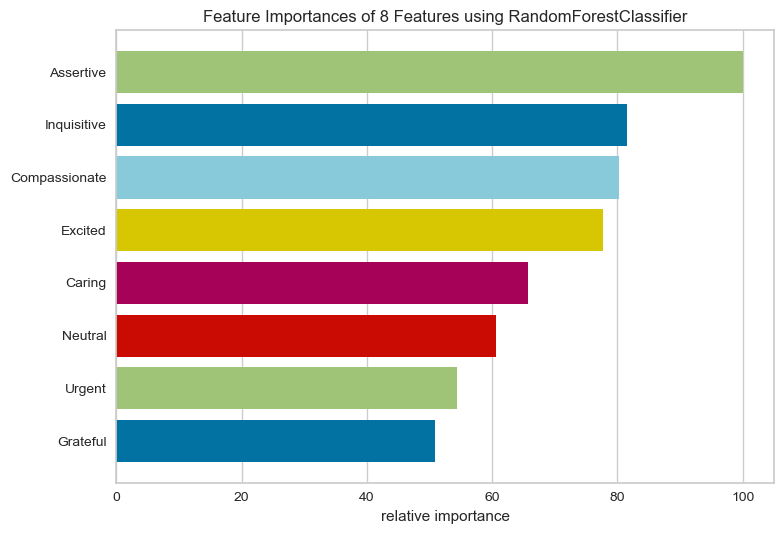

<AxesSubplot:title={'center':'Feature Importances of 8 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [63]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(X_features, y)
viz.show()

#model.fit(X, y, **kwargs)



In [66]:
from sklearn.metrics import f1_score

expected  = y
predicted = model.predict(X_features)

# Compute and return F1 (harmonic mean of precision and recall)
print("{}: {}".format(model.__class__.__name__, f1_score(expected, predicted)))

RandomForestClassifier: 0.7499999999999999


In [70]:
Y_opens.unique()

array([1, 0])

In [72]:
from sklearn.metrics import accuracy_score, classification_report

#print(classification_report(y_test, y_pred, target_names=y_test.unique()))
print(classification_report(expected, predicted, target_names=Y_opens.unique().astype('str')))

              precision    recall  f1-score   support

           1       0.77      0.92      0.84      1562
           0       0.86      0.66      0.75      1239

    accuracy                           0.80      2801
   macro avg       0.82      0.79      0.79      2801
weighted avg       0.81      0.80      0.80      2801

